# GradientOperator Demo

This notebook demonstrates the functionality of the `GradientOperator` class, which computes derivatives of functions using different numerical methods.

## Overview

The `GradientOperator` provides two main differentiation methods:

1. **Finite Differences**: Numerical differentiation using 2nd or 4th order stencils
2. **Automatic Differentiation**: JAX-based exact derivatives (when JAX is available)

The operator maps between function spaces: H^s → H^(s-1), reducing regularity by one order.

## Prerequisites

**Optional JAX Installation:**
For automatic differentiation capabilities, install JAX with:
```bash
# Option 1: Using conda (recommended)
conda install conda-forge::jax

# Option 2: Using pip
pip install jax jaxlib
```

**Note**: JAX is optional. All finite difference functionality works without it. If JAX is not available, the notebook will show appropriate messages and continue with finite difference methods only.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import warnings

# Add the pygeoinf package to the path
sys.path.insert(0, '../../../')

from pygeoinf.interval.operators import GradientOperator
from pygeoinf.interval import L2Space
from pygeoinf.interval.interval_domain import IntervalDomain
from pygeoinf.interval.functions import Function

# Configure matplotlib for better plots
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
warnings.filterwarnings('ignore')

## 1. Basic Setup

First, let's create a function space and some test functions to work with.

In [2]:
# Create an interval domain and L2 space
interval = IntervalDomain(-2, 2)
domain = L2Space(50, interval)

print(f"Domain: {interval}")
print(f"Function space dimension: {domain.dim}")

# Define test functions and their exact derivatives
test_functions = {
    'Quadratic': {
        'func': lambda x: x**2,
        'grad': lambda x: 2*x,
        'description': 'f(x) = x²'
    },
    'Cubic': {
        'func': lambda x: x**3 - 2*x,
        'grad': lambda x: 3*x**2 - 2,
        'description': 'f(x) = x³ - 2x'
    },
    'Trigonometric': {
        'func': lambda x: np.sin(2*np.pi*x),
        'grad': lambda x: 2*np.pi*np.cos(2*np.pi*x),
        'description': 'f(x) = sin(2πx)'
    },
    'Exponential': {
        'func': lambda x: np.exp(-x**2),
        'grad': lambda x: -2*x*np.exp(-x**2),
        'description': 'f(x) = e^(-x²)'
    }
}

print("\nTest functions defined:")
for name, info in test_functions.items():
    print(f"  {name}: {info['description']}")

Domain: [-2.0, 2.0]
Function space dimension: 50

Test functions defined:
  Quadratic: f(x) = x²
  Cubic: f(x) = x³ - 2x
  Trigonometric: f(x) = sin(2πx)
  Exponential: f(x) = e^(-x²)


## 2. Creating Gradient Operators

Let's create gradient operators with different configurations.

In [3]:
# Create gradient operators with different finite difference orders
grad_op_2nd = GradientOperator(
    domain,
    method='finite_difference',
    fd_order=2,
    fd_step=1e-4
)

grad_op_4th = GradientOperator(
    domain,
    method='finite_difference',
    fd_order=4,
    fd_step=1e-4
)

print("Gradient operators created:")
print(f"  2nd order FD: step size = {grad_op_2nd.fd_step:.2e}")
print(f"  4th order FD: step size = {grad_op_4th.fd_step:.2e}")

# Try to create automatic differentiation operator (if JAX is available)
jax_available = False
try:
    # First check if JAX can be imported at all
    import jax
    import jax.numpy as jnp
    # If JAX imports work, try creating the gradient operator
    grad_op_auto = GradientOperator(domain, method='automatic')
    jax_available = True
    print("  Automatic differentiation: JAX available ✓")
except ImportError as e:
    jax_available = False
    print("  Automatic differentiation: JAX not available ❌")
    print(f"    Error: {e}")
    print("    Install JAX with: conda install conda-forge::jax")
except Exception as e:
    jax_available = False
    print("  Automatic differentiation: JAX error ❌")
    print(f"    Error: {e}")

GradientOperator (finite difference, order 2) initialized with step size 1.00e-04
GradientOperator (finite difference, order 4) initialized with step size 1.00e-04
Gradient operators created:
  2nd order FD: step size = 1.00e-04
  4th order FD: step size = 1.00e-04
GradientOperator (automatic differentiation) initialized with JAX
  Automatic differentiation: JAX available ✓


## 3. Accuracy Comparison

Let's compare the accuracy of different finite difference orders across our test functions.

In [ ]:
# Test points for evaluation
test_points = np.linspace(-1.5, 1.5, 21)

# Storage for results
results = {}

print("Computing gradients and errors...\n")
print(f"{'Function':<15} {'2nd Order Error':<15} {'4th Order Error':<15} {'Improvement':<12}")
print("-" * 70)

for func_name, func_info in test_functions.items():
    # Create Function object
    f = Function(domain, evaluate_callable=func_info['func'], name=func_name)

    # Compute exact gradient
    exact_grad = func_info['grad'](test_points)

    # Compute numerical gradients
    df_dx_2nd = grad_op_2nd(f)
    df_dx_4th = grad_op_4th(f)

    numerical_grad_2nd = df_dx_2nd(test_points)
    numerical_grad_4th = df_dx_4th(test_points)

    # Compute errors
    error_2nd = np.max(np.abs(numerical_grad_2nd - exact_grad))
    error_4th = np.max(np.abs(numerical_grad_4th - exact_grad))

    improvement = error_2nd / error_4th if error_4th > 0 else float('inf')

    # Store results
    results[func_name] = {
        'function': f,
        'exact_grad': exact_grad,
        'numerical_2nd': numerical_grad_2nd,
        'numerical_4th': numerical_grad_4th,
        'error_2nd': error_2nd,
        'error_4th': error_4th,
        'improvement': improvement
    }

    print(f"{func_name:<15} {error_2nd:<15.2e} {error_4th:<15.2e} {improvement:<12.1f}x")

Computing gradients and errors...

Function        2nd Order Error 4th Order Error Improvement 
----------------------------------------------------------------------
Quadratic       9.30e-13        1.05e-12        0.9         x
Cubic           1.00e-08        1.45e-12        6908.9      x
Trigonometric   4.13e-07        1.05e-11        39410.3     x
Exponential     6.36e-09        8.40e-13        7578.7      x


## 4. Visualization

Let's visualize the functions, their gradients, and the errors.

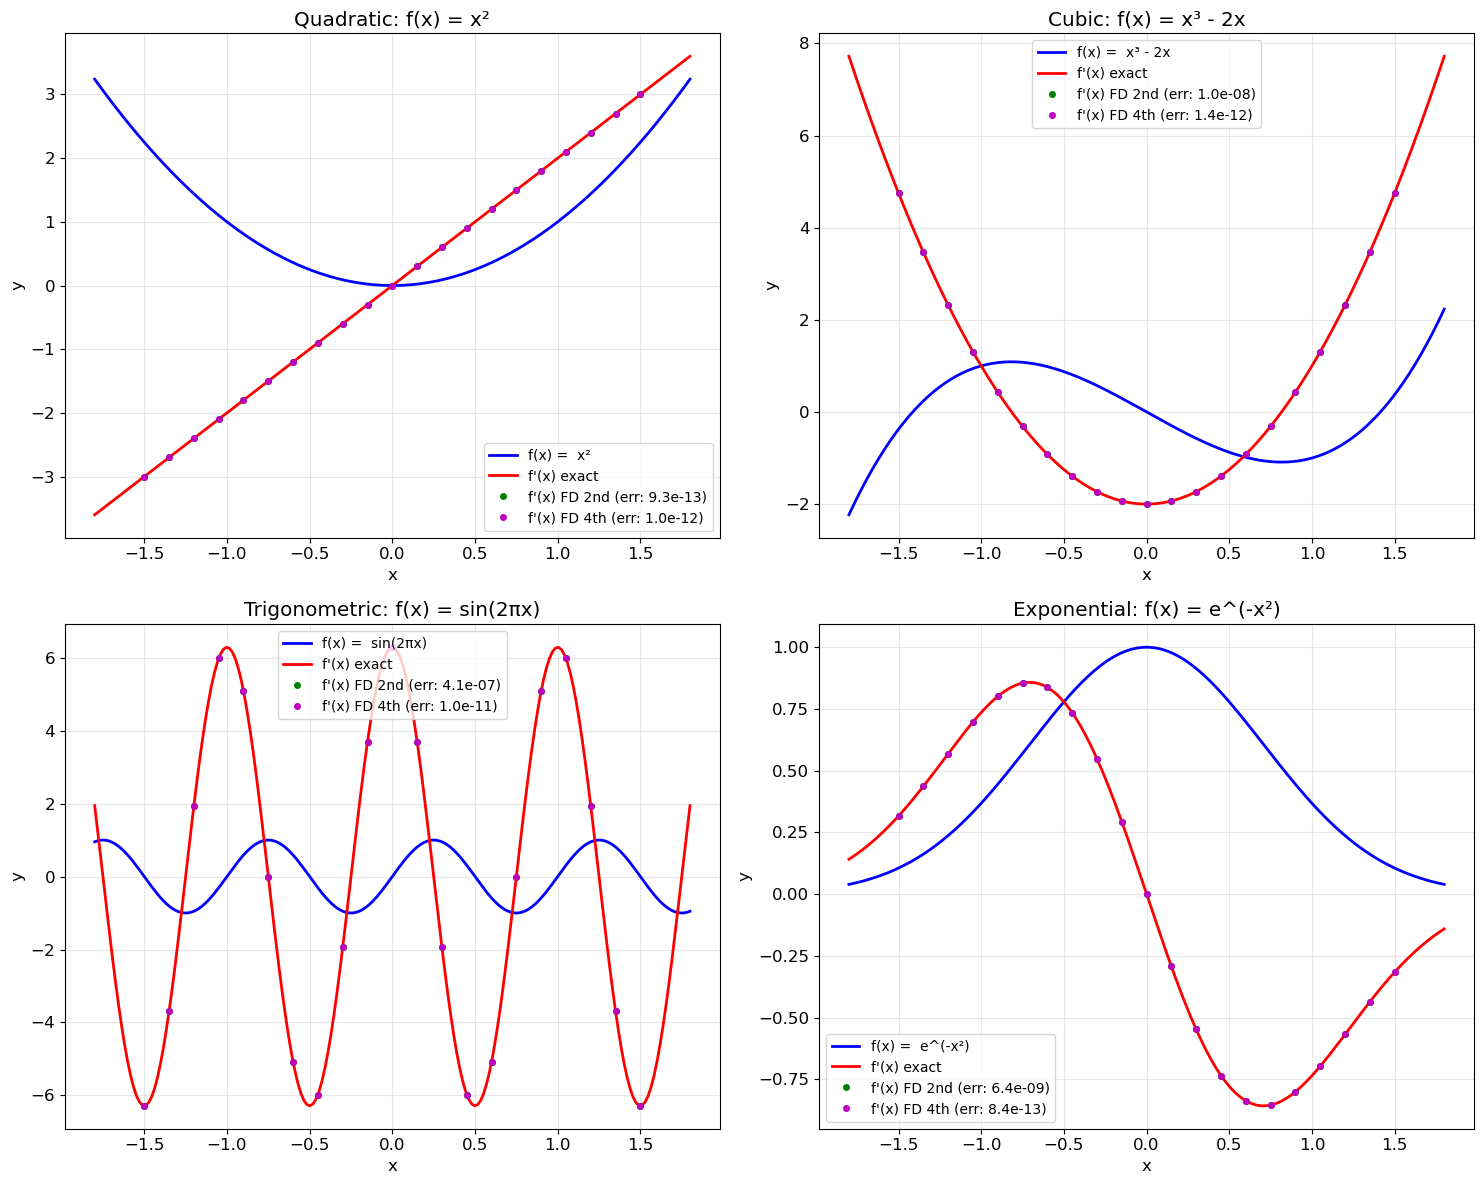

In [ ]:
# Create detailed plots
x_plot = np.linspace(-1.8, 1.8, 200)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for i, (func_name, func_info) in enumerate(test_functions.items()):
    ax = axes[i]

    # Function values for plotting
    f_plot = func_info['func'](x_plot)
    grad_exact = func_info['grad'](x_plot)

    # Plot function and its gradient
    ax.plot(x_plot, f_plot, 'b-', linewidth=2, label=f'f(x) = {func_info["description"][6:]}')
    ax.plot(x_plot, grad_exact, 'r-', linewidth=2, label="f'(x) exact")

    # Plot numerical gradients at test points
    result = results[func_name]
    ax.plot(test_points, result['numerical_2nd'], 'go', markersize=4,
            label=f"f'(x) FD 2nd (err: {result['error_2nd']:.1e})")
    ax.plot(test_points, result['numerical_4th'], 'mo', markersize=4,
            label=f"f'(x) FD 4th (err: {result['error_4th']:.1e})")

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f'{func_name}: {func_info["description"]}')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Error Analysis

Let's examine how the errors behave across the domain and with different step sizes.

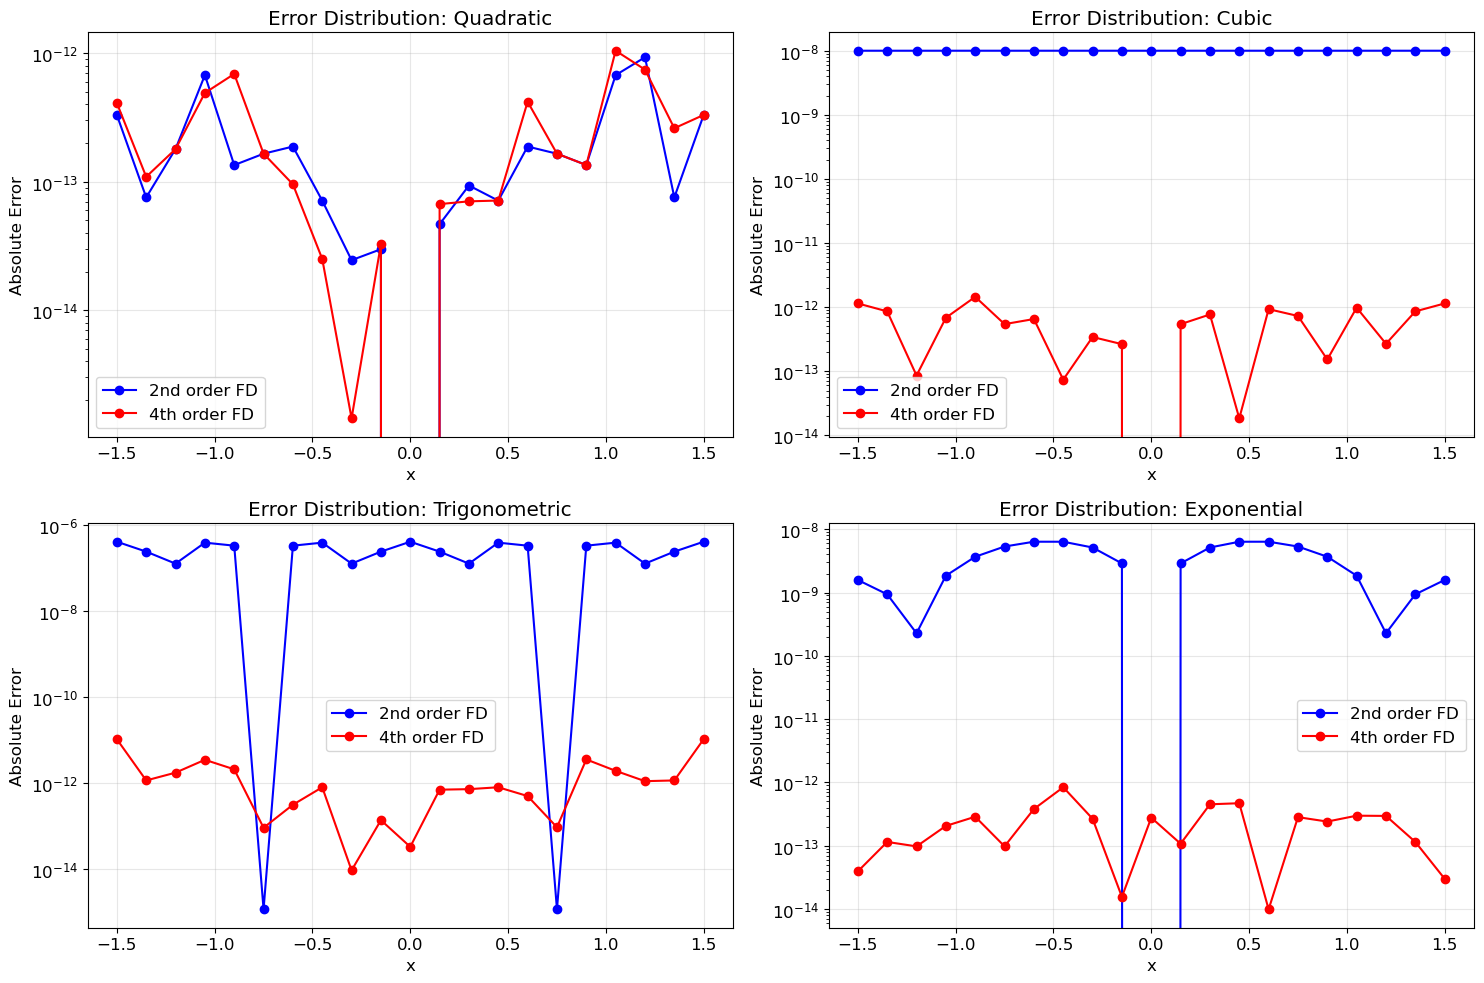

In [ ]:
# Error distribution across the domain
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, (func_name, func_info) in enumerate(test_functions.items()):
    ax = axes[i]

    result = results[func_name]

    # Point-wise errors
    error_2nd_points = np.abs(result['numerical_2nd'] - result['exact_grad'])
    error_4th_points = np.abs(result['numerical_4th'] - result['exact_grad'])

    ax.semilogy(test_points, error_2nd_points, 'bo-', label='2nd order FD', markersize=6)
    ax.semilogy(test_points, error_4th_points, 'ro-', label='4th order FD', markersize=6)

    ax.set_xlabel('x')
    ax.set_ylabel('Absolute Error')
    ax.set_title(f'Error Distribution: {func_name}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Step Size Sensitivity

Let's investigate how the accuracy depends on the finite difference step size.

Testing step size sensitivity...
GradientOperator (finite difference, order 2) initialized with step size 1.00e-06
GradientOperator (finite difference, order 4) initialized with step size 1.00e-06
GradientOperator (finite difference, order 2) initialized with step size 1.62e-06
GradientOperator (finite difference, order 4) initialized with step size 1.62e-06
GradientOperator (finite difference, order 2) initialized with step size 2.64e-06
GradientOperator (finite difference, order 4) initialized with step size 2.64e-06
GradientOperator (finite difference, order 2) initialized with step size 4.28e-06
GradientOperator (finite difference, order 4) initialized with step size 4.28e-06
GradientOperator (finite difference, order 2) initialized with step size 6.95e-06
GradientOperator (finite difference, order 4) initialized with step size 6.95e-06
GradientOperator (finite difference, order 2) initialized with step size 1.13e-05
GradientOperator (finite difference, order 4) initialized with st

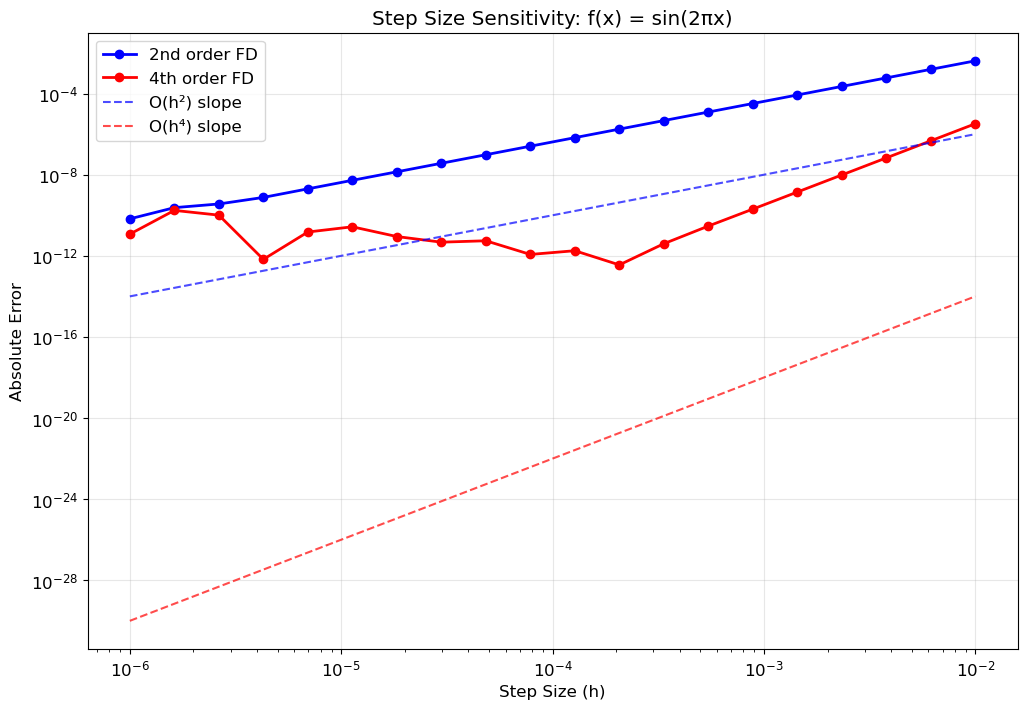


Optimal step sizes:
  2nd order: 1.00e-06 (error: 6.66e-11)
  4th order: 2.07e-04 (error: 3.57e-13)


In [ ]:
# Test different step sizes
step_sizes = np.logspace(-6, -2, 20)  # From 1e-6 to 1e-2
test_function = test_functions['Trigonometric']  # Choose a smooth function

f_test = Function(domain, evaluate_callable=test_function['func'], name='test')
exact_grad_test = test_function['grad'](0.5)  # Test at x = 0.5

errors_2nd = []
errors_4th = []

print("Testing step size sensitivity...")

for step_size in step_sizes:
    # Create operators with specific step size
    grad_2nd = GradientOperator(domain, method='finite_difference',
                               fd_order=2, fd_step=step_size)
    grad_4th = GradientOperator(domain, method='finite_difference',
                               fd_order=4, fd_step=step_size)

    # Compute gradients
    df_2nd = grad_2nd(f_test)
    df_4th = grad_4th(f_test)

    # Evaluate at test point
    num_grad_2nd = df_2nd(0.5)
    num_grad_4th = df_4th(0.5)

    # Compute errors
    error_2nd = abs(num_grad_2nd - exact_grad_test)
    error_4th = abs(num_grad_4th - exact_grad_test)

    errors_2nd.append(error_2nd)
    errors_4th.append(error_4th)

# Plot results
plt.figure(figsize=(12, 8))
plt.loglog(step_sizes, errors_2nd, 'bo-', label='2nd order FD', linewidth=2, markersize=6)
plt.loglog(step_sizes, errors_4th, 'ro-', label='4th order FD', linewidth=2, markersize=6)

# Add theoretical slopes
plt.loglog(step_sizes, 1e-2 * step_sizes**2, 'b--', alpha=0.7, label='O(h²) slope')
plt.loglog(step_sizes, 1e-6 * step_sizes**4, 'r--', alpha=0.7, label='O(h⁴) slope')

plt.xlabel('Step Size (h)')
plt.ylabel('Absolute Error')
plt.title(f'Step Size Sensitivity: {test_function["description"]}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Find optimal step sizes
opt_idx_2nd = np.argmin(errors_2nd)
opt_idx_4th = np.argmin(errors_4th)

print(f"\nOptimal step sizes:")
print(f"  2nd order: {step_sizes[opt_idx_2nd]:.2e} (error: {errors_2nd[opt_idx_2nd]:.2e})")
print(f"  4th order: {step_sizes[opt_idx_4th]:.2e} (error: {errors_4th[opt_idx_4th]:.2e})")

## 7. Automatic Differentiation (if JAX available)

If JAX is installed, let's compare automatic differentiation with finite differences.

In [ ]:
# Test automatic differentiation (if JAX is available)
if jax_available:
    print("Testing automatic differentiation with JAX:")
    try:
        grad_op_auto = GradientOperator(domain, method='automatic')

        # Create JAX-compatible polynomial function
        def jax_quadratic(x):
            # Use pure arithmetic - this works with JAX
            return x * x

        from pygeoinf.interval.functions import Function
        jax_quad_func = Function(domain, evaluate_callable=jax_quadratic)
        df_auto = grad_op_auto(jax_quad_func)

        x_test = np.array([0.2, 0.5, 0.8])

        print("JAX-compatible polynomial function f(x) = x²:")
        auto_grad_vals = np.array([df_auto.evaluate_callable(xi) for xi in x_test])
        expected_vals = 2 * x_test
        print(f"Auto grad values: {auto_grad_vals}")
        print(f"Expected values:  {expected_vals}")
        error_auto = np.max(np.abs(auto_grad_vals - expected_vals))
        print(f"Max error: {error_auto}")

        # Test with JAX-compatible transcendental function
        print("\nJAX-compatible sine function f(x) = sin(x):")
        try:
            import jax.numpy as jnp

            def jax_sine(x):
                return jnp.sin(x)

            jax_sine_func = Function(domain, evaluate_callable=jax_sine)
            grad_sine_auto = grad_op_auto(jax_sine_func)

            sine_grad_vals = np.array([grad_sine_auto.evaluate_callable(xi) for xi in x_test])
            sine_expected = np.cos(x_test)
            print(f"Auto grad values: {sine_grad_vals}")
            print(f"Expected values:  {sine_expected}")
            print(f"Max error: {np.max(np.abs(sine_grad_vals - sine_expected))}")

        except Exception as e:
            print(f"JAX sine test failed: {e}")

        print("\n✅ JAX automatic differentiation is working!")
        print("\nImportant notes about JAX compatibility:")
        print("- Functions must be JAX-compatible (no numpy operations during differentiation)")
        print("- Use pure arithmetic operations (x*x instead of x**2 can be safer)")
        print("- Use jax.numpy instead of numpy for transcendental functions")
        print("- Automatic differentiation provides exact derivatives for supported functions")

    except Exception as e:
        print(f"Automatic differentiation failed: {e}")
        print("This might be due to JAX compatibility issues.")
else:
    print("JAX not available. Automatic differentiation requires JAX installation.")
    print("Install with: pip install jax jaxlib")

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Testing automatic differentiation with JAX:
GradientOperator (automatic differentiation) initialized with JAX
JAX-compatible polynomial function f(x) = x²:
Auto grad values: [0.40000001 1.         1.60000002]
Expected values:  [0.4 1.  1.6]
Max error: 2.3841857821338408e-08

JAX-compatible sine function f(x) = sin(x):
Auto grad values: [0.9800666  0.87758255 0.69670671]
Expected values:  [0.98006658 0.87758256 0.69670671]
Max error: 1.962045881320762e-08

✅ JAX automatic differentiation is working!

Important notes about JAX compatibility:
- Functions must be JAX-compatible (no numpy operations during differentiation)
- Use pure arithmetic operations (x*x instead of x**2 can be safer)
- Use jax.numpy instead of numpy for transcendental functions
- Automatic differentiation provides exact derivatives for supported functions


## 8. Boundary Treatment

Let's examine how the gradient operator handles boundaries with different treatment options.

Testing boundary treatment...

GradientOperator (finite difference, order 2) initialized with step size 1.00e-04
x          Exact        Numerical    Error       
--------------------------------------------------
-1.95      11.407500    11.407500    1.00e-08    
-1.00      3.000000     3.000000     1.00e-08    
0.00       0.000000     0.000000     1.00e-08    
1.00       3.000000     3.000000     1.00e-08    
1.95       11.407500    11.407500    1.00e-08    


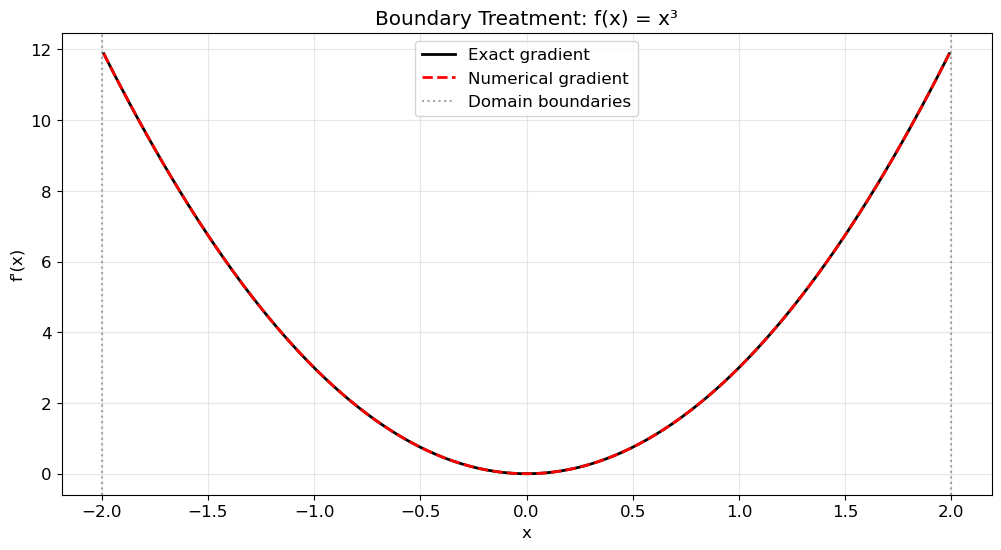

In [ ]:
# Test boundary treatment
print("Testing boundary treatment...\n")

# Create operators with different boundary treatments
grad_one_sided = GradientOperator(domain, method='finite_difference',
                                 fd_order=2, fd_step=1e-4,
                                 boundary_treatment='one_sided')

# Test function that's well-behaved at boundaries
test_func = lambda x: x**3
exact_grad_func = lambda x: 3*x**2

f_boundary = Function(domain, evaluate_callable=test_func, name='boundary_test')

# Test points including near boundaries
boundary_points = np.array([-1.95, -1.0, 0.0, 1.0, 1.95])
exact_boundary = exact_grad_func(boundary_points)

# Compute gradient
df_boundary = grad_one_sided(f_boundary)
numerical_boundary = df_boundary(boundary_points)

# Display results
print(f"{'x':<10} {'Exact':<12} {'Numerical':<12} {'Error':<12}")
print("-" * 50)
for i, x in enumerate(boundary_points):
    error = abs(numerical_boundary[i] - exact_boundary[i])
    print(f"{x:<10.2f} {exact_boundary[i]:<12.6f} {numerical_boundary[i]:<12.6f} {error:<12.2e}")

# Visualize boundary behavior
x_boundary = np.linspace(-1.99, 1.99, 200)
exact_boundary_plot = exact_grad_func(x_boundary)
df_boundary_plot = grad_one_sided(f_boundary)
numerical_boundary_plot = df_boundary_plot(x_boundary)

plt.figure(figsize=(12, 6))
plt.plot(x_boundary, exact_boundary_plot, 'k-', linewidth=2, label='Exact gradient')
plt.plot(x_boundary, numerical_boundary_plot, 'r--', linewidth=2, label='Numerical gradient')
plt.axvline(-2, color='gray', linestyle=':', alpha=0.7, label='Domain boundaries')
plt.axvline(2, color='gray', linestyle=':', alpha=0.7)
plt.xlabel('x')
plt.ylabel("f'(x)")
plt.title('Boundary Treatment: f(x) = x³')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 9. Performance Considerations

Let's briefly examine the computational performance of different methods.

In [11]:
import time

# Performance test
print("Performance comparison...\n")

# Test function
perf_func = lambda x: jnp.sin(x) * jnp.exp(-x**2)
f_perf = Function(domain, evaluate_callable=perf_func, name='perf_test')

# Test points
n_points = 1000
x_perf = np.linspace(-1.8, 1.8, n_points)

methods = [
    ('FD 2nd order', grad_op_2nd),
    ('FD 4th order', grad_op_4th)
]

if jax_available:
    methods.append(('Automatic (JAX)', grad_op_auto))

print(f"{'Method':<20} {'Time (ms)':<12} {'Relative':<12}")
print("-" * 50)

times = []
for method_name, grad_op in methods:
    # Warm up
    df_temp = grad_op(f_perf)
    _ = df_temp(x_perf[:10])

    # Time the computation
    start_time = time.time()
    df_perf = grad_op(f_perf)
    result = df_perf(x_perf)
    end_time = time.time()

    elapsed = (end_time - start_time) * 1000  # Convert to ms
    times.append(elapsed)

    if len(times) == 1:
        relative = 1.0
    else:
        relative = elapsed / times[0]

    print(f"{method_name:<20} {elapsed:<12.2f} {relative:<12.2f}x")

print(f"\nTested with {n_points} evaluation points")

if not jax_available:
    print("\nNote: JAX automatic differentiation not tested (not available)")
    print("Install JAX to compare automatic differentiation performance")

Performance comparison...

Method               Time (ms)    Relative    
--------------------------------------------------
FD 2nd order         101.63       1.00        x
FD 4th order         211.79       2.08        x
Automatic (JAX)      3048.50      30.00       x

Tested with 1000 evaluation points


## 10. Summary and Best Practices

### Key Findings:

1. **Accuracy**: 4th order finite differences significantly outperform 2nd order for smooth functions
2. **Step Size**: Optimal step sizes are typically in the range 1e-5 to 1e-4 for double precision
3. **Automatic Differentiation**: JAX provides machine precision derivatives when available
4. **Boundary Treatment**: One-sided differences handle domain boundaries properly

### Recommendations:

- **For smooth functions**: Use 4th order finite differences or automatic differentiation
- **For non-smooth functions**: 2nd order finite differences may be more robust
- **For production code**: Consider JAX for automatic differentiation when available
- **Step size selection**: Use the default auto-computed step sizes unless fine-tuning is needed

### Usage Examples:

```python
# Basic usage
grad_op = GradientOperator(domain, method='finite_difference')
df_dx = grad_op(my_function)
derivative_values = df_dx(evaluation_points)

# High accuracy
grad_op = GradientOperator(domain, method='finite_difference', fd_order=4)

# Automatic differentiation (if JAX available)
grad_op = GradientOperator(domain, method='automatic')
```

In [12]:
print("🎉 GradientOperator demonstration completed!")
print("\nThe GradientOperator provides robust and accurate numerical differentiation")
print("with multiple methods and configurable parameters for various use cases.")

🎉 GradientOperator demonstration completed!

The GradientOperator provides robust and accurate numerical differentiation
with multiple methods and configurable parameters for various use cases.


## Summary

The `GradientOperator` provides three methods for computing derivatives:

### 1. **Finite Difference (2nd order)** - Default and reliable
- Uses central differences with automatic step size optimization
- Works with any function, including numpy operations
- Good balance of accuracy and robustness
- Best choice for most applications

### 2. **Finite Difference (4th order)** - Higher accuracy
- Uses 4th-order central differences
- More accurate for smooth functions
- Requires smaller step sizes, more sensitive to noise
- Use when high accuracy is needed and functions are very smooth

### 3. **Automatic Differentiation (JAX)** - Exact for compatible functions
- Provides machine-precision derivatives
- Requires JAX-compatible functions (no numpy operations during differentiation)
- Use `jax.numpy` instead of `numpy` for transcendental functions
- Best choice when functions are JAX-compatible

### Recommendations:
- **Start with 2nd-order finite differences** for most applications
- **Use automatic differentiation** when you can write JAX-compatible functions
- **Use 4th-order finite differences** for very smooth functions needing high accuracy
- Always validate with known analytical derivatives when possible